Get Pandas and NumPy for feature engineering and calculations and get plots inline.

In [1]:
import pandas as pd
import numpy  as np

from pyearth import Earth
from pyearth import export

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# File parameters prefixed pf_

pf_casurl = 'https://covid.ourworldindata.org/data/'
pf_casfil = 'owid-covid-data.csv'       # case file name

pf_datrdc = [                           # columns to read as dates
    3,
]
pf_datcol = 'date'                      # date column
pf_dimcol = 'iso_code'                  # dimension column (location or otherwise)
pf_cascol = [                           # case columns (new, not cumulative)
    'new_cases',
    'new_deaths',
]
pf_namcol = 'location'                  # full dim name
pf_popcol = 'population'                # population column
pf_futext = '365 days'                  # future extension of dataframe
pf_datmrg = '0 days'                    # date margin to ignore at end

We use the daily file from OWID containing new cases and deaths per country per day.

In [4]:
url = pf_casurl + pf_casfil
!wget -N $url

--2023-10-31 09:08:56--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.26.2.153, 104.26.3.153, 172.67.73.95, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.26.2.153|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://covid-19.nyc3.digitaloceanspaces.com/public/owid-covid-data.csv [following]
--2023-10-31 09:08:56--  https://covid-19.nyc3.digitaloceanspaces.com/public/owid-covid-data.csv
Resolving covid-19.nyc3.digitaloceanspaces.com (covid-19.nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to covid-19.nyc3.digitaloceanspaces.com (covid-19.nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92303150 (88M) [binary/octet-stream]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv 100%[===================>]  88.03M  1.51MB/s    in 51s     

2023-10-31 09:09:47 (1

We read our dataframe directly from the downloaded file and have a look at the last records for format. Originally, data for Namibia caused missing values because the ISO-2 code is __NA__, so we disable default interpretation of missing values.

In [5]:
df = pd.read_csv(
    pf_casfil,
    keep_default_na = False,
    na_values       = '',
    parse_dates     = pf_datrdc,
    dayfirst        = True,
)

# show the last rows as columns in reverse order
(
    df
    .tail(5)
    .transpose()
    .loc[:, ::-1]
)

351815  \
iso_code                                                 ZWE   
continent                                             Africa   
location                                            Zimbabwe   
date                                     2023-10-25 00:00:00   
total_cases                                         265821.0   
...                                                      ...   
population                                        16320539.0   
excess_mortality_cumulative_absolute                     NaN   
excess_mortality_cumulative                              NaN   
excess_mortality                                         NaN   
excess_mortality_cumulative_per_million                  NaN   

                                                      351814  \
iso_code                                                 ZWE   
continent                                             Africa   
location                                            Zimbabwe   
date                                     2023-10-24 00:00:00   
total_cases                                         265821.0   
...                                                      ...   
population                                        16320539.0   
excess_mortality_cumulative_absolute                     NaN   
excess_mortality_cumulative                              NaN   
excess_mortality                                         NaN   
excess_mortality_cumulative_per_million                  NaN   

                                                      351813  \
iso_code                                                 ZWE   
continent                                             Africa   
location                                            Zimbabwe   
date                                     2023-10-23 00:00:00   
total_cases                                         265821.0   
...                                                      ...   
population                                        16320539.0   
excess_mortality_cumulative_absolute                     NaN   
excess_mortality_cumulative                              NaN   
excess_mortality                                         NaN   
excess_mortality_cumulative_per_million                  NaN   

                                                      351812  \
iso_code                                                 ZWE   
continent                                             Africa   
location                                            Zimbabwe   
date                                     2023-10-22 00:00:00   
total_cases                                         265821.0   
...                                                      ...   
population                                        16320539.0   
excess_mortality_cumulative_absolute                     NaN   
excess_mortality_cumulative                              NaN   
excess_mortality                                         NaN   
excess_mortality_cumulative_per_million                  NaN   

                                                      351811  
iso_code                                                 ZWE  
continent                                             Africa  
location                                            Zimbabwe  
date                                     2023-10-21 00:00:00  
total_cases                                         265821.0  
...                                                      ...  
population                                        16320539.0  
excess_mortality_cumulative_absolute                     NaN  
excess_mortality_cumulative                              NaN  
excess_mortality                                         NaN  
excess_mortality_cumulative_per_million                  NaN  

[67 rows x 5 columns]

Drop data with missing identifier, determine the last date and provide a last check of our source dataframe.

In [6]:
df = (
    df
    .dropna(
        subset=[
            pf_dimcol,
        ],
    )
)

lastdate = (
    (
        df
        [pf_datcol]
        .max()
    )
    - pd.Timedelta(pf_datmrg)
)
(
    df
    .count()
)

iso_code                                   351816
continent                                  335071
location                                   351816
date                                       351816
total_cases                                313796
                                            ...  
population                                 351816
excess_mortality_cumulative_absolute        12205
excess_mortality_cumulative                 12205
excess_mortality                            12205
excess_mortality_cumulative_per_million     12205
Length: 67, dtype: int64

We pivot to a country by column format.

In [7]:
df_dim = (
    df
    .pivot_table(
        index   = pf_datcol,
        columns = pf_dimcol,
        values  = pf_cascol,
        aggfunc = 'sum',
    )
    .fillna(0)
)

df_dim

new_cases                                               ...  \
iso_code         ABW  AFG  AGO  AIA  ALB  AND  ARE  ARG  ARM  ASM  ...   
date                                                               ...   
2020-01-01       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-02       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-03       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-04       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-05       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023-10-26       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-10-27       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-10-28       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-10-29       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-10-30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

           new_deaths                                               
iso_code          VGB  VIR  VNM  VUT  WLF  WSM  YEM  ZAF  ZMB  ZWE  
date                                                                
2020-01-01        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-02        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-03        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-04        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-05        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2023-10-26        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2023-10-27        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2023-10-28        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2023-10-29        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2023-10-30        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1399 rows x 510 columns]

For predictions later on we need extra rows in our dataframe. One of the ways to do that is reindexing with a larger range, so we add to the current range and check our latest date.

In [8]:
new_index = (
    pd.date_range(
        (
            df_dim
            .index
            .min()
        ),
        (
            (
                df_dim
                .index
                .max()
            )
            + pd.Timedelta(pf_futext)
        ),
    )
)
df_dim = (
    df_dim
    .reindex(
        new_index,
    )
)
df_dim

new_cases                                               ...  \
iso_code         ABW  AFG  AGO  AIA  ALB  AND  ARE  ARG  ARM  ASM  ...   
2020-01-01       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-02       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-03       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-04       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2020-01-05       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2024-10-25       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2024-10-26       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2024-10-27       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2024-10-28       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2024-10-29       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

           new_deaths                                               
iso_code          VGB  VIR  VNM  VUT  WLF  WSM  YEM  ZAF  ZMB  ZWE  
2020-01-01        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-02        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-03        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-04        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2020-01-05        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2024-10-25        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2024-10-26        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2024-10-27        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2024-10-28        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2024-10-29        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[1764 rows x 510 columns]

We need numerical data as inputs for a model, so we add a column representing the date as days since the start of the index.

In [9]:
df_dim['daynum'] = (
    (
        (
            df_dim
            .index
        )
        -
        (
            df_dim
            .index
            .min()
        )
    )
    .days
)
(
    df_dim
    ['daynum']
    .describe()
)

count    1764.000000
mean      881.500000
std       509.367255
min         0.000000
25%       440.750000
50%       881.500000
75%      1322.250000
max      1763.000000
Name: daynum, dtype: float64

The typical progress of an outbreak seems to fit a Gumbel distribution, where the cumulative distribution is a double negative exponent: `exp(-exp(-x))`. The measures are averaged by week to smooth out reporting lags.

In [10]:
def gumpdf(x, beta, mu):
    """Return PDF value according to Gumbel"""
    expon = -((x - mu) / beta)
    return np.exp(expon) * np.exp(-(np.exp(expon))) / beta

def gumcdf(x, beta, mu):
    """Return CDF value according to Gumbel"""
    expon = -((x - mu) / beta)
    return np.exp(-(np.exp(expon)))

In [11]:
import matplotlib as mpl
mpl.rc(
    'figure',
    max_open_warning=0,
)

In [12]:
# Run parameters prefixed pr_

pr_measure  = 'new_cases'               # file column to use as measure
pr_smeasure = 'Week window'             # smoothed measures
pr_rmeasure = 'rcases'                  # remaining measures after iteration
pr_pmeasure = 'Model'                   # projected measures summed
pr_wmeasure = 'Wave '                   # wave name prefix, zero-leading number is added
pr_wavenum  = 3                         # wave numbering width

pr_sdays    = 7                         # number of days for smoothing window
pr_firstwav = 1                         # initial wave number
pr_popcases = 9e9                       # relative minimum from population size (one in n cases)
pr_mincases = 2                         # absolute minimum number of cases to consider

pr_linmax   = -8/20                     # upper bound of linear derivation
pr_linmin   = -8/2                      # lower bound of linear derivation
pr_betamax  = 80/2                      # maximum accepted beta estimate
pr_datamin  = 3                         # minimum number of data points in spline
pr_projmin  = 1                         # minimum cases for projected start and floor
pr_gradmin  = 1e-6                      # minimum gradient difference for knot
pr_wavesig  = 1/10                      # minimum significance for wave

pr_plotshw  = True                      # show plots
pr_plotmin  = '20200101'                # start date of output plots
pr_plotmax  = '20231001'                # stop date of output plots

pr_earth = {                            # pyearth parameters
    'minspan'     : 1,                  # minimal length of spline
    'penalty'     : 0,                  # strictness in pruning
    'endspan'     : 0,                  # measures allowed remaining
    'thresh'      : 1e-9,               # improvement threshold for knot
    'check_every' : 1,                  # measures considered
}
pr_plot = {                             # plot parameters
    'figsize'     : (16, 9),            # figure size
    'grid'        : True,               # show grid
    'kind'        : 'area',             # plot kind
    'stacked'     : False,              # stacking
    'alpha'       : 1/3,                # transparency
}
pr_legend = {                           # legend parameters
    'loc'         : 'upper left',       # location
    'fontsize'    : 'small',            # font size
    'framealpha'  : 1/2,                # transparency
    'ncol'        : 3,                  # number of columns
#    'mode'        : 'expand',
}
pr_plnew    = 'Daily new cases for '    # title start for new measure plot
pr_plcum    = 'Cumulative cases for '   # title start for cumulative measure plot

pr_pldate   = (
    ' - '
    + lastdate.strftime('%Y-%m-%d')
)

# Messages

pr_msg_data = '--- no data left'        # not enough data for another fit
pr_msg_wave = '--- no data for wave'    # not enough data for another wave
pr_msg_spur = '--- spurious wave'       # fitted wave probably spurious


Running multiple wave analysis for Netherlands with population 17564020
Minimum number of cases is 2
Wave 001 beta 16.680 mu  101 fit 0.853 peak 2020-04-11 from 2020-03-03 to 2020-08-23 size 50806
Wave 002 beta  9.094 mu  207 fit 0.685 peak 2020-07-26 from 2020-07-08 to 2020-09-19 size 3649
Wave 003 beta 13.639 mu  231 fit 0.565 peak 2020-08-19 from 2020-07-20 to 2020-11-26 size 19436
--- no data for wave


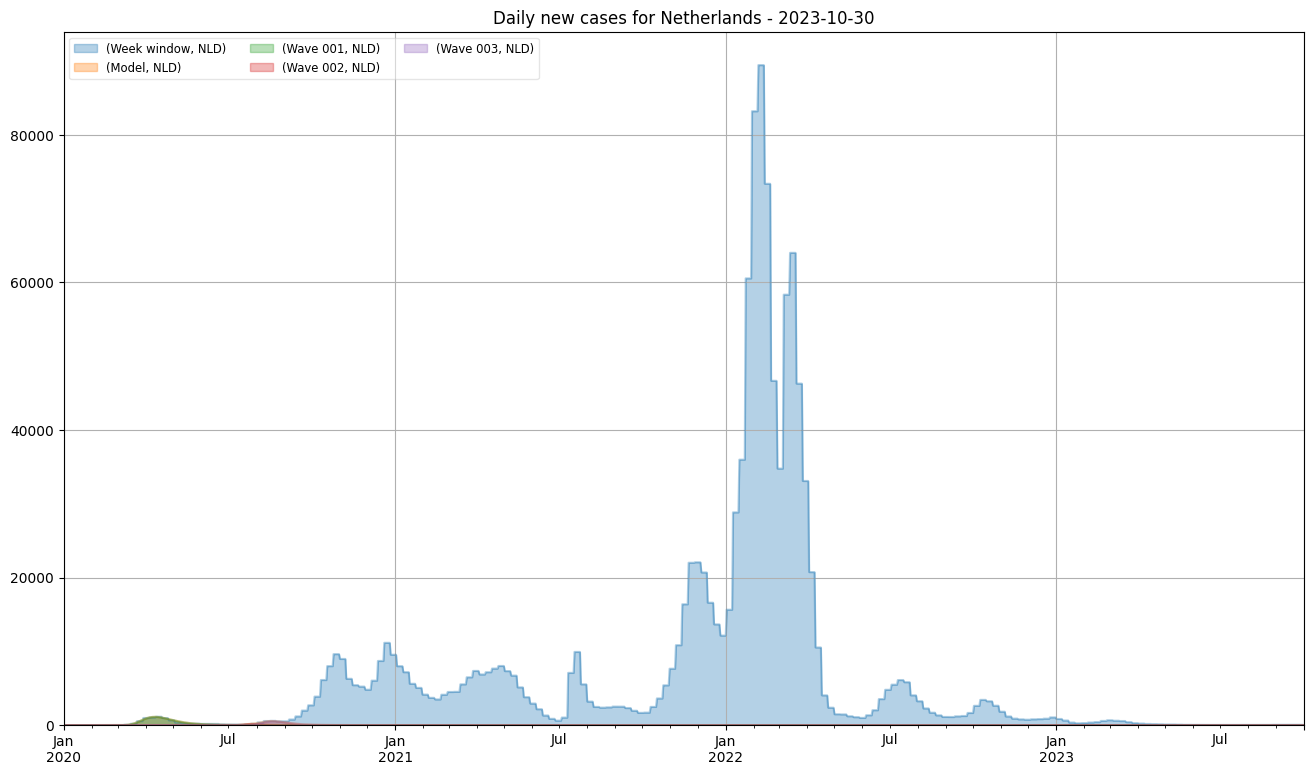

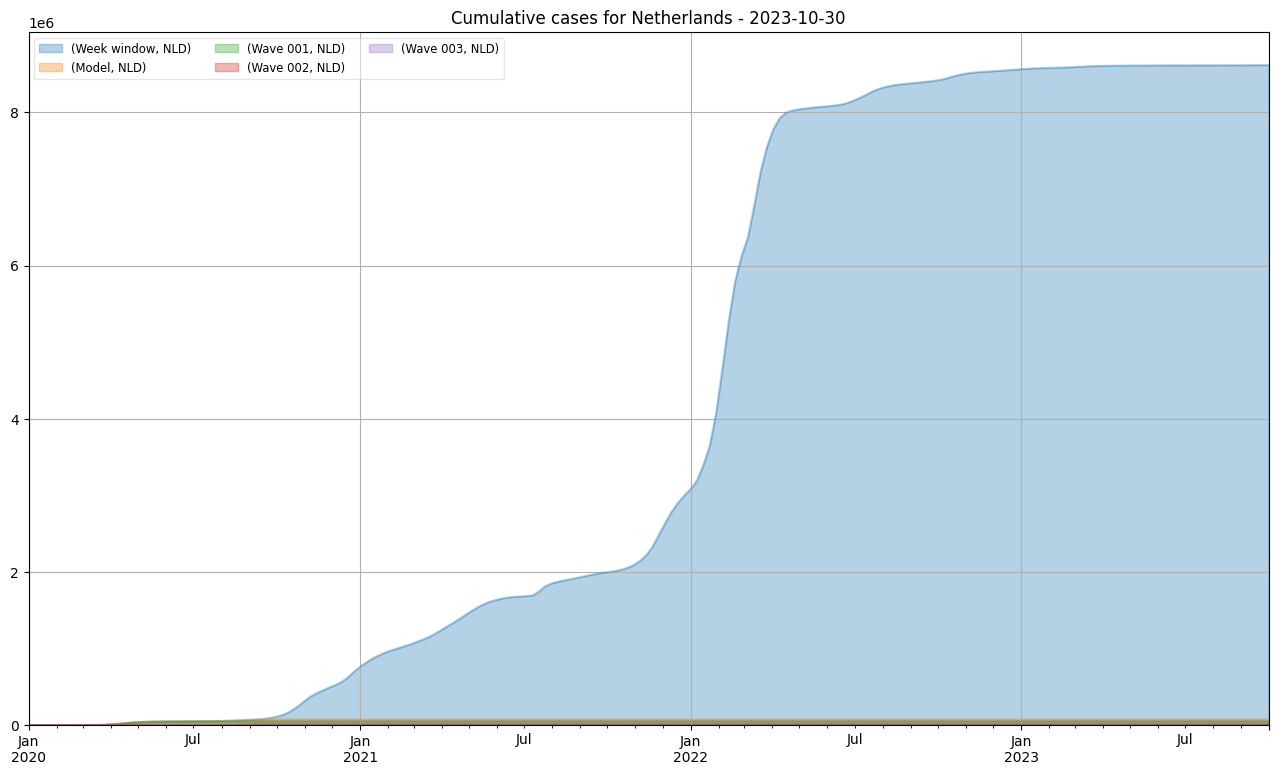

In [13]:
#dimlist = (df[pf_dimcol].unique())
dimlist = [
    'NLD',
#    'JPN',
#    'PHL',
#    'IND',
#    'ZAF',
#    'CHN',
#    'NZL',
#    'KEN',
#    'BHS',
#    'ISR',
#    'BEL',
#    'LUX',
#    'DEU',
#    'GBR',
#    'USA',
#    'BRA',
#    'FRA',
#    'ITA',
#    'ESP',
#    'PRT',
#    'OWID_WRL',
]

for pr_dim in dimlist:

    wave = pr_firstwav

    # Initialize predicted measure, create smoothed measure and remaining cases
    df_dim[(pr_pmeasure, pr_dim)] = 0
    df_dim[(pr_smeasure, pr_dim)] = (
        df_dim
        [pr_measure]
        [pr_dim]
        .loc[:lastdate]
        .rolling(pr_sdays)
        .mean()
    )
    df_dim[(pr_rmeasure, pr_dim)] = (
        df_dim
        [pr_smeasure]
        [pr_dim]
    )

    # Always plot smoothed and predicted measures, adding waves when found
    plotlist = [
        (pr_smeasure, pr_dim),
        (pr_pmeasure, pr_dim),
    ]

    # Get full name and population from the original dataset
    dimnam = (
        df
        [
            df
            [pf_dimcol]
            == pr_dim
        ]
        [pf_namcol]
        .iloc[-1]
    )
    dimpop = (
        df
        [
            df
            [pf_dimcol]
            == pr_dim
        ]
        [pf_popcol]
        .iloc[-1]
    )

    # We use a relative minimum number of cases, but at least an absolute
    mincases = max(
        dimpop / pr_popcases,
        pr_mincases,
    )

    print(
        'Running multiple wave analysis for {} with population {:1.0f}'
        .format(
            dimnam,
            dimpop,
        )
    )
    print(
        'Minimum number of cases is {:1.0f}'
        .format(
            mincases,
        )
    )

    while True:
        # Create potential wave
        curwave = (
            pr_wmeasure
            + str(
                wave 
                + 10 ** pr_wavenum
            )
            [-pr_wavenum:]
        )
        df_dim[(curwave, pr_dim)] = 0

        # Create a dataframe for projections
        df_proj = pd.DataFrame(
            {
                'daynum':
                    (
                        df_dim
                        ['daynum']
                    ),
                'measure':
                    (
                        df_dim
                        [pr_rmeasure]
                        [pr_dim]
                    ),
            }
        )

        # Create the Gumbel division and select suitable measures
        df_proj['gumdiv'] = (
            (
                df_proj
                ['measure']
            )
            /
            (
                df_proj
                ['measure']
                .cumsum()
            )
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ['gumdiv']
                    > 0
                ) 
                &
                (
                    df_proj
                    ['measure']
                    > mincases
                )
            ]
        )

        # Reduce to log scale and select relevant measures
        df_proj['linear'] = (
            np.log(
                df_proj
                ['gumdiv']
            )
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ['linear']
                    < pr_linmax
                ) 
                &
                (
                    df_proj
                    ['linear']
                    > pr_linmin
                )
            ]
        )

        # Do we still have data left?
        if len(df_proj) <= 1:
            print(pr_msg_data)
            break

        # Create input vectors for regression splines and build a model
        eax = (
            df_proj
            ['daynum']
            .values
            .reshape(-1, 1)
        )
        eay = (
            df_proj
            ['linear']
            .values
            .reshape(-1, 1)
        )
        eamodel = Earth(**pr_earth)
        (
            eamodel
            .fit(
                eax,
                eay,
            )
        )

        # Store the results
        df_proj['earth'] = (
            eamodel
            .predict(
                eax,
            )
        )

        # Find the day range
        daymin = (
            df_proj
            ['daynum']
            .min()
        )
        daymax = (
            df_proj
            ['daynum']
            .max()
        )

        # Find the gradient of generated regression splines
        df_proj['gbgrad'] = (
            (
                df_proj
                ['linear']
            )
            -
            (
                df_proj
                ['linear']
                .shift(1)
            )
        )
        df_proj['eagrad'] = (
            (
                df_proj
                ['earth']
            )
            -
            (
                df_proj
                ['earth']
                .shift(1)
            )
        )

        # Knots are found when the gradient changes, including start and end
        df_proj['knot'] = (
            (
                abs(
                    (
                        df_proj
                        ['eagrad']
                    )
                    - 
                    (
                        df_proj
                        ['eagrad']
                        .shift(1)
                    )
                )
                > pr_gradmin
            ) 
            |
            (
                df_proj
                ['daynum']
                == (daymin + 1)
            ) 
            |
            (
                df_proj
                ['daynum']
                == daymax
            )
        )

        # Starting day of each spline
        df_proj['daycount'] = (
            df_proj
            .reset_index()
            .index
        )
        
        # Select the knots and find the actual number of days for each spline
        df_knot = (
            df_proj
            [
                df_proj
                ['knot']
            ]
            [
                [
                    'daynum',
                    'daycount',
                    'eagrad',
                ]
            ]
        )
        
        df_knot['daysdata'] = (
            (
                df_knot
                ['daycount']
                .shift(-1)
            )
            -
            (
                df_knot
                ['daycount']
            )
        )
        df_knot['daystime'] = (
            (
                df_knot
                ['daynum']
                .shift(-1)
            )
            -
            (
                df_knot
                ['daynum']
            )
        )

        # Candidate knots have a negative gradient and a minimum number of days
        df_knot['cand'] = (
            (
                df_knot
                ['eagrad']
                < - (1 / pr_betamax)
            ) 
            &
            (
                df_knot
                ['daysdata']
                >= pr_datamin
            )
        )

        # We want early knots with a low gradient and many days
        df_knot['since'] = (
            (
                df_knot
                ['daynum']
            )
            - daymin
        )
        df_knot['score'] = (
            (
                df_knot
                ['eagrad']
                ** 2
            ) 
            *
            np.sqrt(
                (
                    df_knot
                    ['daysdata']
                )
                /
                np.sqrt(
                    df_knot
                    ['since']
                )
            )
        )
        df_knot['choice'] = (
            (
                df_knot
                ['score']
            )
            ==
            (
                df_knot
                [
                    df_knot
                    ['cand']
                ]
                ['score']
                .max()
            )
        )

        # Did we find another wave?
        choice = (
            df_knot
            [
                df_knot
                ['choice']
            ]
        )
        if len(choice) == 0:
            print(pr_msg_wave)
            break

        # Find the interval of the selected spline
        lower = (
            choice
            ['daynum']
            .values[0]
        )
        upper = (
            choice
            ['daysdata']
            .values[0]
            + lower
        )
        df_proj = (
            df_proj
            [
                (
                    df_proj
                    ['daynum']
                    >= lower
                ) 
                &
                (
                    df_proj
                    ['daynum']
                    <= upper
                )
            ]
            .copy()
        )

        # Calculate slope and intercept as basis for beta and mu
        fitmod = export.export_python_function(eamodel)
        slope = (
            (
                fitmod([[upper]])[0]
                - fitmod([[lower]])[0]
            ) 
            /
            (
                upper
                - lower
            )
        )
        intercept = (
            fitmod([[lower]])[0]
            - (lower * slope)
        )
        beta = - 1 / slope
        mu = beta * (intercept + np.log(beta))

        # Apply the Gumbel PDF according to beta and mu and find the scale
        df_proj['pgumb'] = gumpdf(
            (
                df_proj
                ['daynum']
            ),
            beta,
            mu,
        )
        df_proj['scale'] = (
            (
                df_proj
                ['measure']
            )
            /
            (
                df_proj
                ['pgumb']
            )
        )
        final = (
            df_proj
            ['scale']
            .mean()
        )
        fincv = (
            df_proj
            ['scale']
            .std()
            / final
        )

        # Did we find a spurious wave?
        if ((1 - fincv) ** 2) < pr_wavesig:
            print(pr_msg_spur)
            break

        # Calculate the current wave and its parameters
        df_dim[(curwave, pr_dim)] = (
            gumpdf(
                (
                    df_dim
                    ['daynum']
                ),
                beta,
                mu,
            )
            * final
        )
        peak = (
            df_dim
            [
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                )
                == 
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    .max()
                )
            ]
            .index
            .min()
        )
        start = (
            df_dim
            [
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    >= pr_projmin
                ) 
                &
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    .index
                    < peak
                )
            ]
            .index
            .min()
        )
        floor = (
            df_dim
            [
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    < pr_projmin
                ) 
                &
                (
                    df_dim
                    [curwave]
                    [pr_dim]
                    .index 
                    > peak
                )
            ]
            .index
            .min()
        )
        print(
            '{} beta {:6.3f} mu {:4.0f} fit {:5.3f} peak {} from {} to {} size {:1.0f}'
            .format(
                curwave,
                beta,
                mu,
                (1 - fincv) ** 2,
                peak.date(),
                start.date(),
                floor.date(),
                final,
            )
        )

        # Move the data from remainder to prediction
        df_dim[(pr_pmeasure, pr_dim)] += (
            df_dim
            [curwave]
            [pr_dim]
        )
        df_dim[(pr_rmeasure, pr_dim)] -= (
            df_dim
            [curwave]
            [pr_dim]
        )
        
        plotlist += [(curwave, pr_dim)]
        wave += 1

    if pr_plotshw:
        (
            df_dim
            [plotlist]
            .loc[pr_plotmin:pr_plotmax]
            .plot(
                **pr_plot,
                title=(
                    pr_plnew
                    + dimnam
                    + pr_pldate
                ),
            )
            .legend(
                **pr_legend,
            )
        )
        (
            df_dim
            [plotlist]
            .loc[pr_plotmin:pr_plotmax]
            .cumsum()
            .plot(
                **pr_plot,
                title=(
                    pr_plcum
                    + dimnam
                    + pr_pldate
                ),
            )
            .legend(
                **pr_legend,
            )
        )

We have the estimate for the final number of cases, so the progress would be the current number of cases divided by the final number. This could end up over 100%, if we estimate that the current wave of the outbreak is over and new cases are due to relaxing of measures, increase in testing or other factors.

In [14]:
progress = (
    (
        df_dim
        [pr_measure]
        [pr_dim]
        .sum()
    )
    /
    (
        df_dim
        [pr_pmeasure]
        [pr_dim]
        .sum()
    )
)
print(
    'Currently at {:1.2f}% of {:1.0f}'
    .format(
        progress * 100,
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .sum()
        ),
    )
)

Currently at 11664.32% of 73890


The peak date is at the maximum value.

In [15]:
peak = (
    df_dim
    [
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
        )
        ==
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .max()
        )
    ]
    .index
    .min()
)
print(
    'Peak at {}'
    .format(
        peak.date(),
    )
)

Peak at 2020-04-11


This date should closely match the `mu` of our distribution, in days since the start of the index.

In [16]:
print(
    'Peak by last mu at {}'
    .format(
        (
            df_dim
            .loc[
                (
                    df_dim
                    ['daynum']
                )
                ==
                (
                    mu
                    .astype(int)
                )
            ]
            .index[0]
            .date()
        ),
    )
)

Peak by last mu at 2020-08-18


The floor is defined as the first time that the number of reported cases falls below 1 in a million, which is the first time that happens *after* the peak.

In [17]:
floor = (
    df_dim
    [
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            < (dimpop / pr_popcases)
        ) 
        &
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .index
            > peak
        )
    ]
    .index
    .min()
)
print(
    'Floor at {}'
    .format(
        floor.date(),
    )
)

Floor at 2021-02-20


Similarly, we can calculate the start as the first day where the number of cases was above 1 in a million before the peak.

In [18]:
start = (
    df_dim
    [
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            > (dimpop / pr_popcases)
        ) 
        &
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .index
            < peak
        )
    ]
    .index
    .min()
)
print(
    'Start at {}'
    .format(
        start.date(),
    )
)

Start at 2020-02-24


We define the maximum delta as the day in the curve with the sharpest rise.

In [19]:
maxrise = (
    (
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
        )
        -
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .shift()
        )
    )
    .max()
)
maxdelta = (
    df_dim
    [
        (
            (
                df_dim
                [pr_pmeasure]
                [pr_dim]
            )
            -
            (
                df_dim
                [pr_pmeasure]
                [pr_dim]
                .shift(1)
            )
        ) 
        == maxrise
    ]
    .index
    .min()
)
print(
    'Largest rise of {:1.0f} on {}'
    .format(
        maxrise,
        maxdelta.date(),
    )
)

Largest rise of 56 on 2020-03-26


This should match the maximum gradient of the daily data.

In [20]:
print(
    'Maximum gradient is {:1.0f}'
    .format(
        (
            np.gradient(
                df_dim
                [pr_pmeasure]
                [pr_dim]
            )
            .max()
        ),
    )
)

Maximum gradient is 56


Back to the original curve, showing the number of infected concurrently.

<AxesSubplot: >

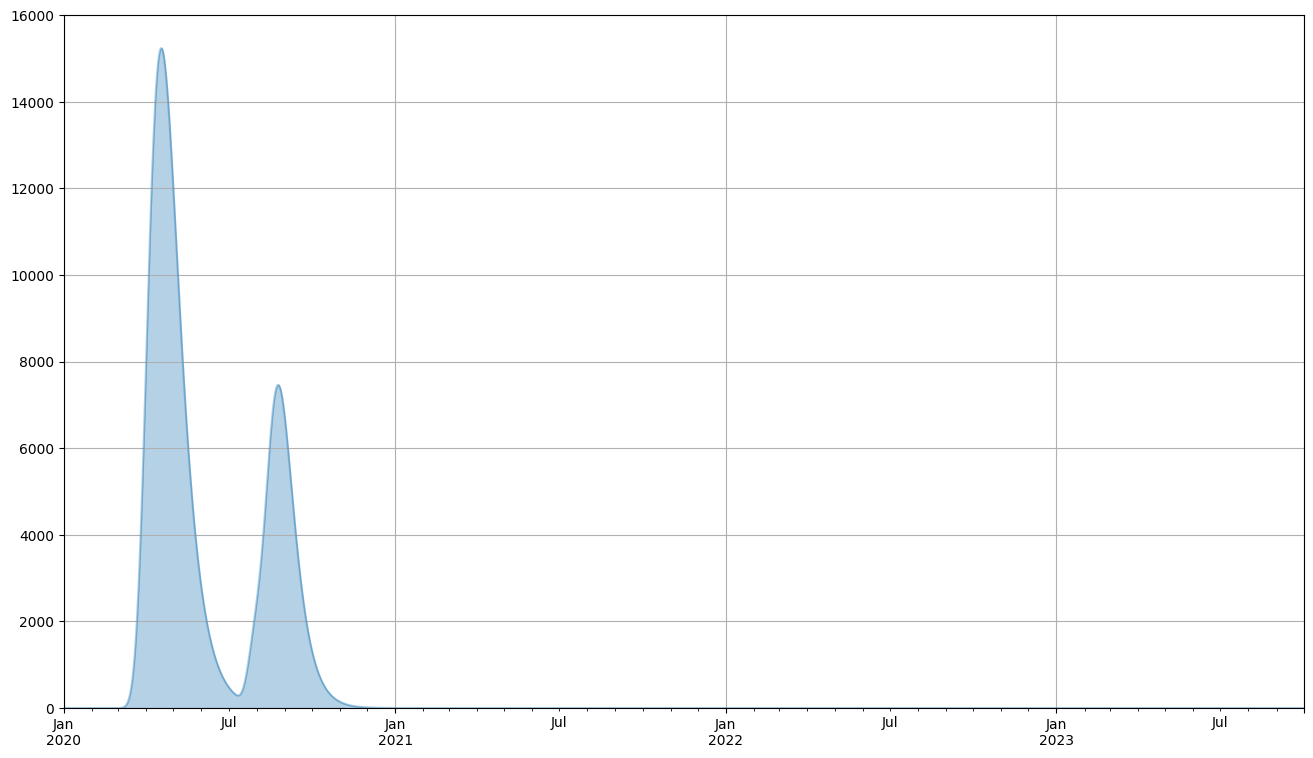

In [21]:
(
    df_dim
    [pr_pmeasure]
    [pr_dim]
    .rolling(14)
    .sum()
    .loc[pr_plotmin:pr_plotmax]
    .plot(
        figsize=(16, 9),
        grid=True,
        kind='area',
        stacked=False,
        alpha=1/3,
    )
)

The top of this curve gives the maximum number of people that are infected at the same time.

In [22]:
print(
    'Maximum infected is {:1.0f}'
    .format(
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .rolling(14)
            .sum()
            .max()
        ),
    )
)

Maximum infected is 15241


An approximation of the infection rate is the number of infected over the last week divided by the number of infectious in the two weeks before that, at least showing outbreak development.

<AxesSubplot: >

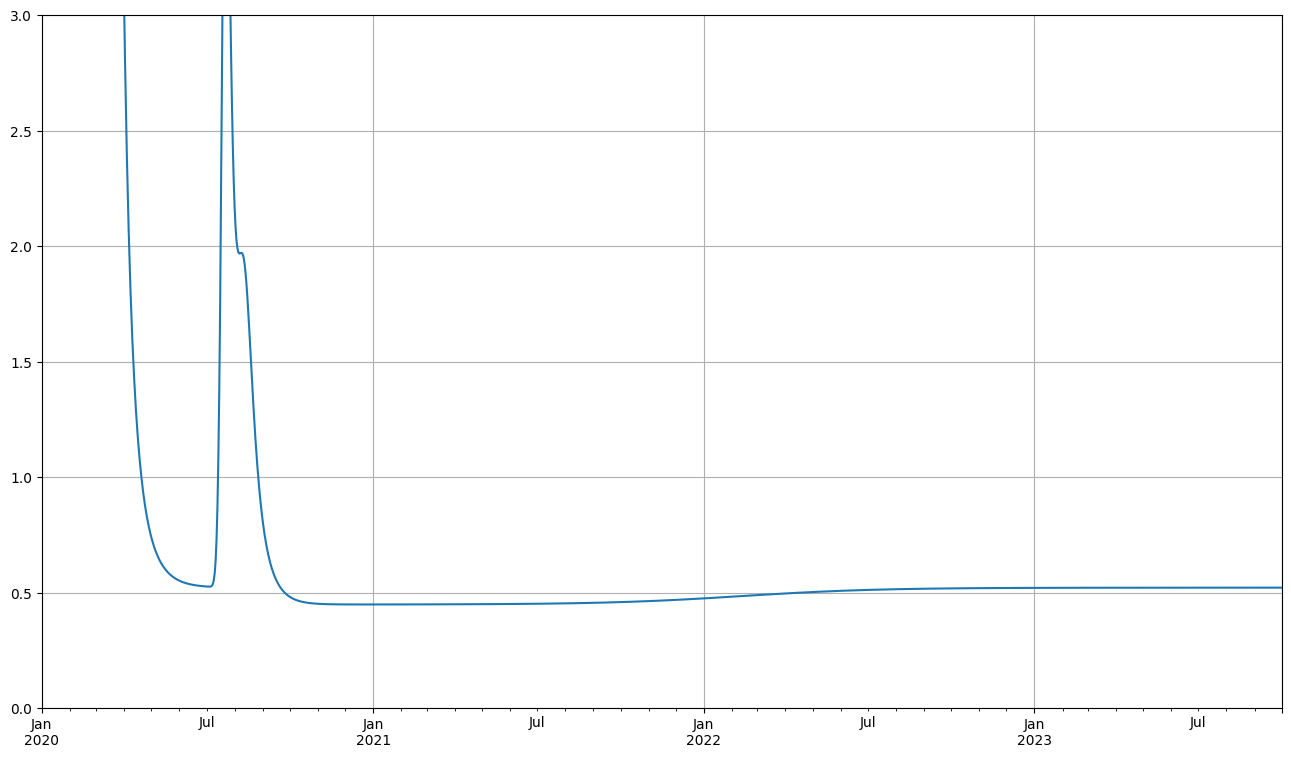

In [23]:
(
    (
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .rolling(7)
            .mean()
        ) 
        /
        (
            df_dim
            [pr_pmeasure]
            [pr_dim]
            .shift(7)
            .rolling(14)
            .mean()
        )
    )
    .loc[pr_plotmin:pr_plotmax]
    .plot(
        figsize=(16, 9),
        grid=True,
        ylim=(0, 3),
    )
)

If we look at the difference between our actual (smoothed) value and our prediction, we can clearly see if the curve is breaking out after the floor. This can be the result of relaxing of measures and the beginning of a next wave, a change in testing or other factors. This also shows the residuals of our fit.

<AxesSubplot: >

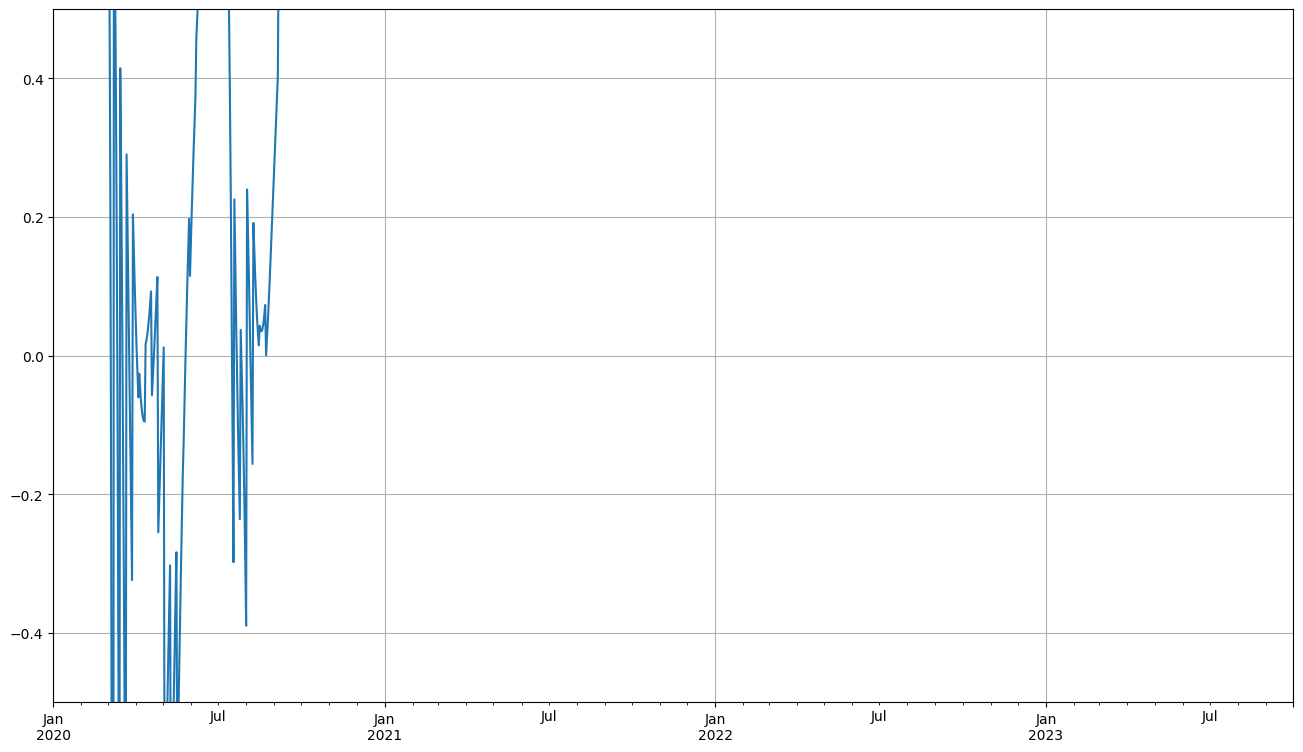

In [24]:
(
    (
#        1 -
        (
            (
                (
                    df_dim
                    [pr_smeasure]
                    [pr_dim]
#                    .cumsum()
                )
                -
                (
                    df_dim
                    [pr_pmeasure]
                    [pr_dim]
#                    .cumsum()
                )
            )
            /
            (
                df_dim
                [pr_smeasure]
                [pr_dim]
#                .cumsum()
            )
        )
#        ** 2
    )
    .rolling(1)
    .mean()
    .loc[pr_plotmin:pr_plotmax]
    .plot(
        figsize=(16, 9),
        grid=True,
        ylim=(-1/2, 1/2),
    )
)

Keep exploring! Stay home, wash your hands, keep your distance.